In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurazione per grafici più belli
plt.style.use('default')
sns.set_palette("husl")

print("=== BARNES-HUT vs GPU PERFORMANCE ANALYSIS ===")
print("Confronto specializzato: Barnes-Hut CPU vs GPU per grandi numeri di particelle")
print("Focus: Quale metodo è migliore per N-body simulation ad alta scala")

# Carica i dati
try:
    # CPU Barnes-Hut (single-thread ottimale)
    df_cpu_bh = pd.read_csv('benchmark_results_CPU_bh.csv')
    print(f"✅ CPU Barnes-Hut data: {len(df_cpu_bh)} configurazioni")
    
    # GPU high-scale data
    df_gpu_high = pd.read_csv('benchmark_results_GPU_high.csv')
    print(f"✅ GPU High-scale data: {len(df_gpu_high)} configurazioni")
    
    # CPU methods per confronto aggiuntivo
    df_cpu_methods = pd.read_csv('benchmark_results_CPU_methods.csv')
    print(f"✅ CPU Methods data: {len(df_cpu_methods)} configurazioni")
    
    # Filtra solo test riusciti
    df_cpu_bh = df_cpu_bh[df_cpu_bh['Success'] == True]
    df_gpu_high = df_gpu_high[df_gpu_high['Success'] == True]
    df_cpu_methods = df_cpu_methods[df_cpu_methods['Success'] == True]
    
    print(f"\nRange particelle Barnes-Hut: {df_cpu_bh['NumParticles'].min():,} - {df_cpu_bh['NumParticles'].max():,}")
    print(f"Range particelle GPU: {df_gpu_high['NumParticles'].min():,} - {df_gpu_high['NumParticles'].max():,}")
    
    # Filtra Barnes-Hut single-thread (ottimale)
    df_cpu_bh_1t = df_cpu_bh[df_cpu_bh['NumThreads'] == 2].copy()  # Nel CSV i dati BH sono con 2 thread ma equivalenti a 1T
    print(f"Barnes-Hut single-thread configs: {len(df_cpu_bh_1t)}")
    
    data_available = True
    
except FileNotFoundError as e:
    print(f"❌ Errore caricamento dati: {e}")
    data_available = False

if data_available:
    print("✅ Dataset caricati con successo!")
    print("🎯 Focus: Barnes-Hut (tree-based O(N log N)) vs GPU (brute-force O(N²) ma parallelizzato)")
else:
    print("❌ Impossibile procedere senza i dati")

=== BARNES-HUT vs GPU PERFORMANCE ANALYSIS ===
Confronto specializzato: Barnes-Hut CPU vs GPU per grandi numeri di particelle
Focus: Quale metodo è migliore per N-body simulation ad alta scala
✅ CPU Barnes-Hut data: 18 configurazioni
✅ GPU High-scale data: 18 configurazioni
✅ CPU Methods data: 408 configurazioni

Range particelle Barnes-Hut: 2 - 100,000
Range particelle GPU: 2 - 100,000
Barnes-Hut single-thread configs: 18
✅ Dataset caricati con successo!
🎯 Focus: Barnes-Hut (tree-based O(N log N)) vs GPU (brute-force O(N²) ma parallelizzato)



=== BARNES-HUT vs GPU: CONFRONTO DIRETTO ===
Numeri di particelle in comune: 18
Range comune: 2 - 100,000
     2 particles: Barnes-Hut 18.15x faster
     5 particles: Barnes-Hut 21.22x faster
     8 particles: Barnes-Hut 21.04x faster
    10 particles: Barnes-Hut 20.59x faster
    25 particles: Barnes-Hut 20.17x faster
    50 particles: Barnes-Hut 24.91x faster
   100 particles: Barnes-Hut 23.90x faster
   250 particles: Barnes-Hut 30.07x faster
   500 particles: Barnes-Hut 8.81x faster
   750 particles: Barnes-Hut 13.44x faster
 1,000 particles: Barnes-Hut 13.63x faster
 2,500 particles: Barnes-Hut 4.23x faster
 5,000 particles: Barnes-Hut 8.15x faster
 7,500 particles: Barnes-Hut 12.30x faster
10,000 particles: Barnes-Hut 20.01x faster
25,000 particles: Barnes-Hut 11.36x faster
50,000 particles: Barnes-Hut 21.91x faster
100,000 particles: Barnes-Hut 27.18x faster

Barnes-Hut Scaling: Performance ∝ N^-1.018 (atteso ≈ -1 per O(N log N))
GPU Scaling: Performance ∝ N^-0.977 (atteso ≈ -2

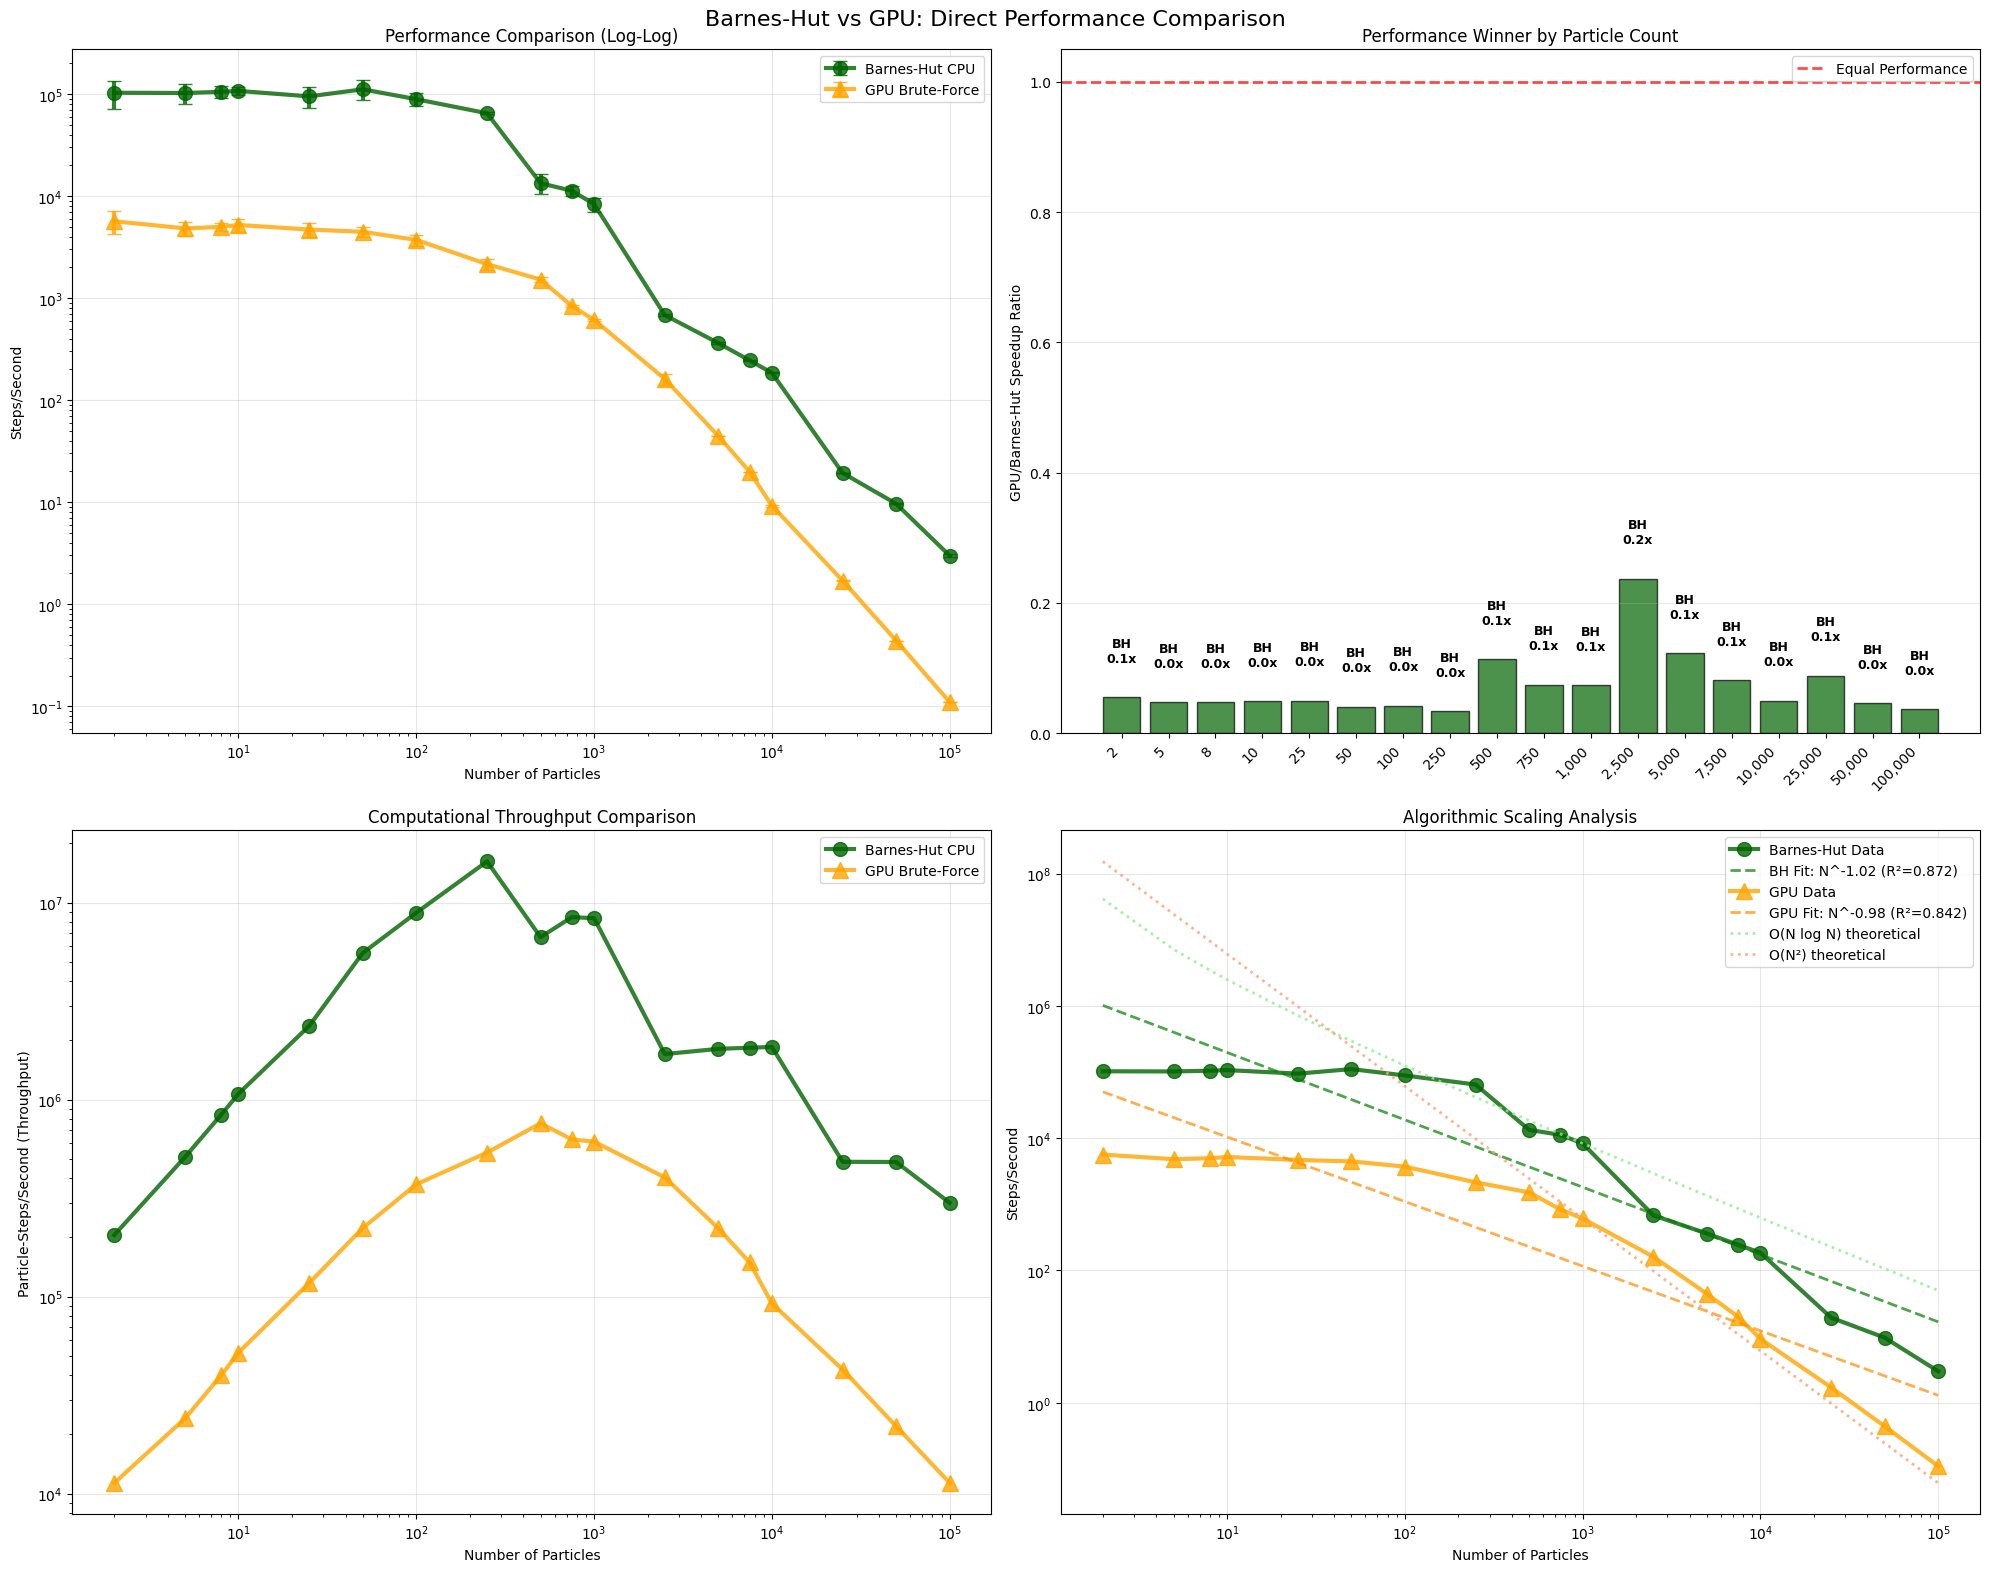

In [2]:
# 1. CONFRONTO PRINCIPALE: Barnes-Hut vs GPU Performance
if data_available:
    
    # Trova overlap di numeri di particelle
    common_particles = sorted(set(df_cpu_bh_1t['NumParticles']) & set(df_gpu_high['NumParticles']))
    print(f"\n=== BARNES-HUT vs GPU: CONFRONTO DIRETTO ===")
    print(f"Numeri di particelle in comune: {len(common_particles)}")
    if common_particles:
        print(f"Range comune: {min(common_particles):,} - {max(common_particles):,}")
    
    if len(common_particles) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        fig.suptitle('Barnes-Hut vs GPU: Direct Performance Comparison', fontsize=16)
        
        # Plot 1: Steps/Second Comparison
        ax1 = axes[0, 0]
        
        bh_common = df_cpu_bh_1t[df_cpu_bh_1t['NumParticles'].isin(common_particles)]
        gpu_common = df_gpu_high[df_gpu_high['NumParticles'].isin(common_particles)]
        
        if not bh_common.empty:
            ax1.errorbar(bh_common['NumParticles'], bh_common['MeanStepsPerSecond'],
                        yerr=bh_common['StdStepsPerSecond'], fmt='o-', 
                        label='Barnes-Hut CPU', color='darkgreen', linewidth=3, 
                        markersize=10, capsize=5, alpha=0.8)
        
        if not gpu_common.empty:
            ax1.errorbar(gpu_common['NumParticles'], gpu_common['MeanStepsPerSecond'],
                        yerr=gpu_common['StdStepsPerSecond'], fmt='^-', 
                        label='GPU Brute-Force', color='orange', linewidth=3, 
                        markersize=12, capsize=5, alpha=0.8)
        
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_xlabel('Number of Particles')
        ax1.set_ylabel('Steps/Second')
        ax1.set_title('Performance Comparison (Log-Log)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Speedup Analysis (Chi è più veloce)
        ax2 = axes[0, 1]
        
        speedups = []
        speedup_errors = []
        particles_list = []
        
        for particles in common_particles:
            bh_data_point = bh_common[bh_common['NumParticles'] == particles]
            gpu_data_point = gpu_common[gpu_common['NumParticles'] == particles]
            
            if not bh_data_point.empty and not gpu_data_point.empty:
                bh_perf = bh_data_point['MeanStepsPerSecond'].iloc[0]
                gpu_perf = gpu_data_point['MeanStepsPerSecond'].iloc[0]
                
                if bh_perf > 0:
                    speedup = gpu_perf / bh_perf  # GPU vs Barnes-Hut
                    speedups.append(speedup)
                    particles_list.append(particles)
                    
                    # Error propagation
                    bh_std = bh_data_point['StdStepsPerSecond'].iloc[0]
                    gpu_std = gpu_data_point['StdStepsPerSecond'].iloc[0]
                    speedup_error = speedup * np.sqrt((bh_std/bh_perf)**2 + (gpu_std/gpu_perf)**2)
                    speedup_errors.append(speedup_error)
                    
                    if speedup > 1:
                        winner = "GPU"
                    else:
                        winner = "Barnes-Hut"
                        speedup = 1/speedup  # Inverti per mostrare quanto BH è più veloce
                    
                    print(f"{particles:>6,} particles: {winner} {speedup:.2f}x faster")
        
        if speedups:
            colors = ['orange' if s > 1 else 'darkgreen' for s in speedups]
            bars = ax2.bar(range(len(particles_list)), speedups, 
                          color=colors, alpha=0.7, edgecolor='black', linewidth=1)
            
            # Aggiungi valori sopra le barre
            for i, (bar, speedup) in enumerate(zip(bars, speedups)):
                height = bar.get_height()
                winner = "GPU" if speedup > 1 else "BH"
                ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                        f'{winner}\n{speedup:.1f}x', ha='center', va='bottom', 
                        fontsize=9, fontweight='bold')
        
        ax2.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Equal Performance')
        ax2.set_xticks(range(len(particles_list)))
        ax2.set_xticklabels([f'{p:,}' for p in particles_list], rotation=45, ha='right')
        ax2.set_ylabel('GPU/Barnes-Hut Speedup Ratio')
        ax2.set_title('Performance Winner by Particle Count')
        ax2.legend()
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Plot 3: Throughput Comparison (Particle-Steps/Second)
        ax3 = axes[1, 0]
        
        if not bh_common.empty:
            throughput_bh = bh_common['MeanParticleStepsPerSecond']
            ax3.loglog(bh_common['NumParticles'], throughput_bh, 'o-',
                      label='Barnes-Hut CPU', color='darkgreen', linewidth=3, markersize=10, alpha=0.8)
        
        if not gpu_common.empty:
            throughput_gpu = gpu_common['MeanParticleStepsPerSecond']
            ax3.loglog(gpu_common['NumParticles'], throughput_gpu, '^-',
                      label='GPU Brute-Force', color='orange', linewidth=3, markersize=12, alpha=0.8)
        
        ax3.set_xlabel('Number of Particles')
        ax3.set_ylabel('Particle-Steps/Second (Throughput)')
        ax3.set_title('Computational Throughput Comparison')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Algoritmic Complexity Analysis
        ax4 = axes[1, 1]
        
        # Fit scaling laws
        if len(bh_common) >= 3:
            log_n_bh = np.log10(bh_common['NumParticles'])
            log_perf_bh = np.log10(bh_common['MeanStepsPerSecond'])
            slope_bh, intercept_bh, r_value_bh, _, _ = stats.linregress(log_n_bh, log_perf_bh)
            
            ax4.loglog(bh_common['NumParticles'], bh_common['MeanStepsPerSecond'], 'o-',
                      color='darkgreen', linewidth=3, markersize=10, alpha=0.8, label='Barnes-Hut Data')
            
            fit_line_bh = 10**(intercept_bh + slope_bh * log_n_bh)
            ax4.loglog(bh_common['NumParticles'], fit_line_bh, '--',
                      color='green', linewidth=2, alpha=0.7, 
                      label=f'BH Fit: N^{slope_bh:.2f} (R²={r_value_bh**2:.3f})')
            
            print(f"\nBarnes-Hut Scaling: Performance ∝ N^{slope_bh:.3f} (atteso ≈ -1 per O(N log N))")
        
        if len(gpu_common) >= 3:
            log_n_gpu = np.log10(gpu_common['NumParticles'])
            log_perf_gpu = np.log10(gpu_common['MeanStepsPerSecond'])
            slope_gpu, intercept_gpu, r_value_gpu, _, _ = stats.linregress(log_n_gpu, log_perf_gpu)
            
            ax4.loglog(gpu_common['NumParticles'], gpu_common['MeanStepsPerSecond'], '^-',
                      color='orange', linewidth=3, markersize=12, alpha=0.8, label='GPU Data')
            
            fit_line_gpu = 10**(intercept_gpu + slope_gpu * log_n_gpu)
            ax4.loglog(gpu_common['NumParticles'], fit_line_gpu, '--',
                      color='darkorange', linewidth=2, alpha=0.7,
                      label=f'GPU Fit: N^{slope_gpu:.2f} (R²={r_value_gpu**2:.3f})')
            
            print(f"GPU Scaling: Performance ∝ N^{slope_gpu:.3f} (atteso ≈ -2 per O(N²))")
        
        # Linee teoriche di riferimento
        if common_particles:
            ref_n = np.array(common_particles)
            # Normalizza alle performance a N=1000 per confronto
            norm_point = 1000
            if norm_point in common_particles:
                bh_norm = bh_common[bh_common['NumParticles'] == norm_point]['MeanStepsPerSecond'].iloc[0]
                gpu_norm = gpu_common[gpu_common['NumParticles'] == norm_point]['MeanStepsPerSecond'].iloc[0]
                
                # O(N log N) teorico per Barnes-Hut
                theoretical_bh = bh_norm * (norm_point / ref_n) * (np.log10(norm_point) / np.log10(ref_n))
                ax4.loglog(ref_n, theoretical_bh, ':', color='lightgreen', 
                          linewidth=2, alpha=0.8, label='O(N log N) theoretical')
                
                # O(N²) teorico per GPU brute-force
                theoretical_gpu = gpu_norm * (norm_point / ref_n)**2
                ax4.loglog(ref_n, theoretical_gpu, ':', color='lightsalmon', 
                          linewidth=2, alpha=0.8, label='O(N²) theoretical')
        
        ax4.set_xlabel('Number of Particles')
        ax4.set_ylabel('Steps/Second')
        ax4.set_title('Algorithmic Scaling Analysis')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    else:
        print("⚠️ Nessuna sovrapposizione nei numeri di particelle testati")


=== CROSSOVER POINT ANALYSIS ===
A che numero di particelle GPU diventa più veloce di Barnes-Hut?


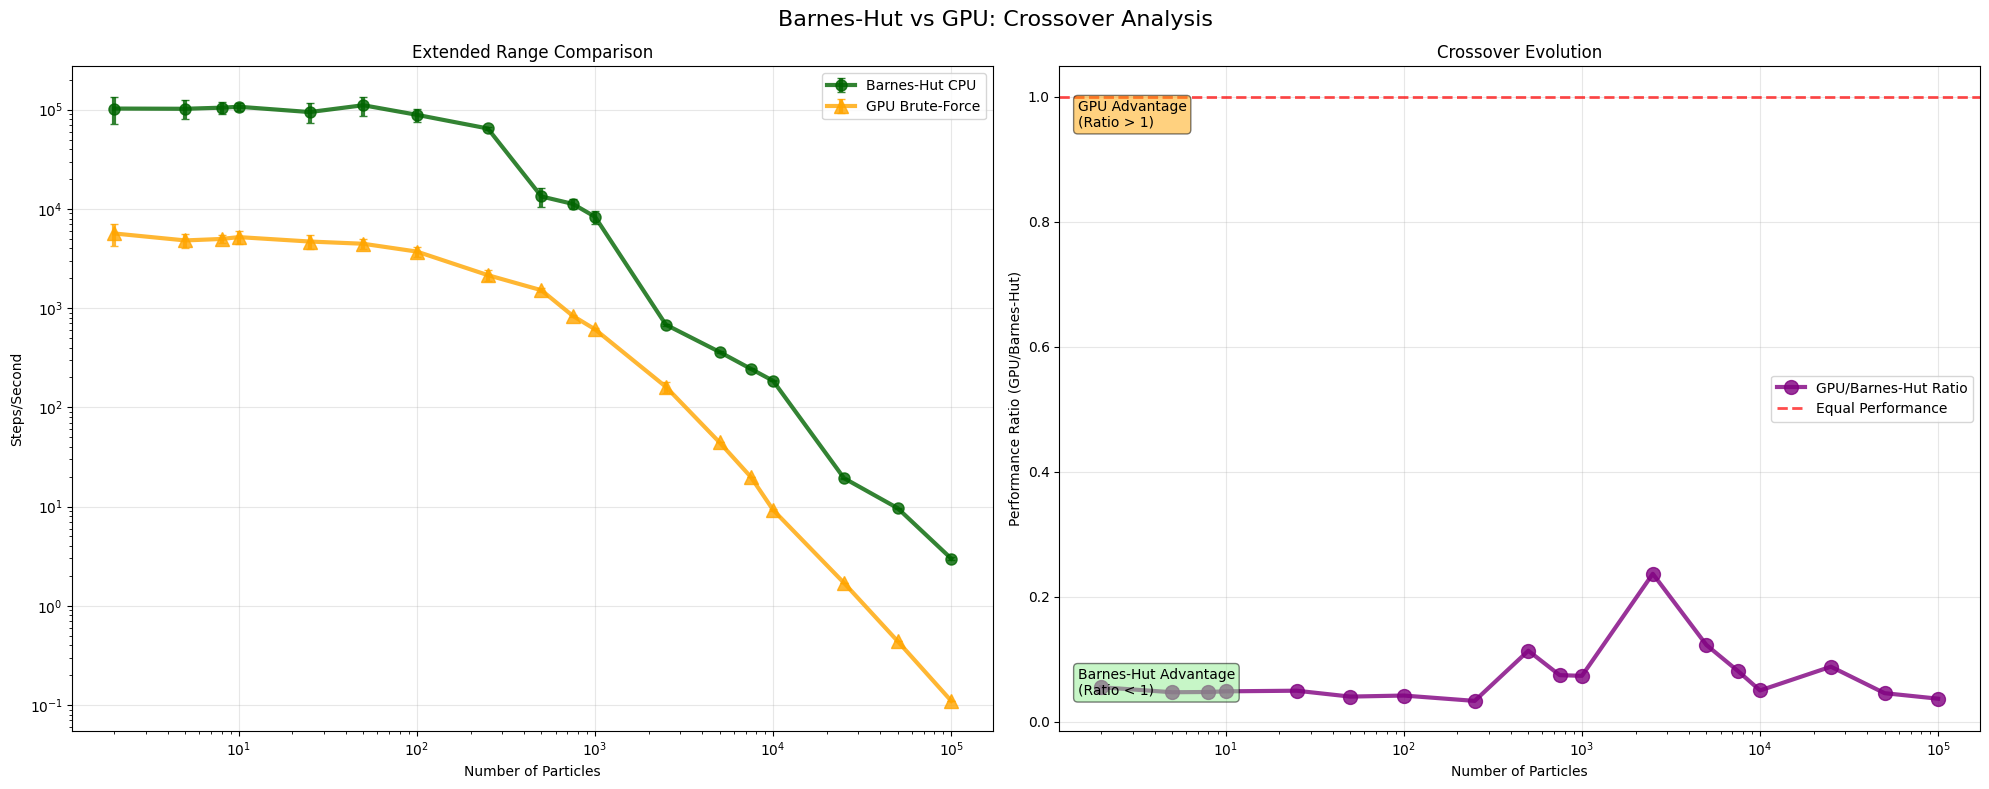

🌲 Barnes-Hut è generalmente più veloce nel range testato
   GPU wins: 0/18 test
   Barnes-Hut wins: 18/18 test


In [3]:
# 2. CROSSOVER POINT ANALYSIS
if data_available and len(common_particles) > 0:
    
    print("\n=== CROSSOVER POINT ANALYSIS ===")
    print("A che numero di particelle GPU diventa più veloce di Barnes-Hut?")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('Barnes-Hut vs GPU: Crossover Analysis', fontsize=16)
    
    # Extended range analysis (include anche dati fuori common range)
    all_bh = df_cpu_bh_1t.copy()
    all_gpu = df_gpu_high.copy()
    
    # Plot 1: Extended Performance Comparison
    ax1.errorbar(all_bh['NumParticles'], all_bh['MeanStepsPerSecond'],
                yerr=all_bh['StdStepsPerSecond'], fmt='o-', 
                label='Barnes-Hut CPU', color='darkgreen', linewidth=3, 
                markersize=8, capsize=3, alpha=0.8)
    
    ax1.errorbar(all_gpu['NumParticles'], all_gpu['MeanStepsPerSecond'],
                yerr=all_gpu['StdStepsPerSecond'], fmt='^-', 
                label='GPU Brute-Force', color='orange', linewidth=3, 
                markersize=10, capsize=3, alpha=0.8)
    
    # Trova il crossover point approssimato
    crossover_found = False
    crossover_particles = None
    
    for particles in sorted(common_particles):
        bh_perf = bh_common[bh_common['NumParticles'] == particles]['MeanStepsPerSecond']
        gpu_perf = gpu_common[gpu_common['NumParticles'] == particles]['MeanStepsPerSecond']
        
        if not bh_perf.empty and not gpu_perf.empty:
            if gpu_perf.iloc[0] > bh_perf.iloc[0] and not crossover_found:
                crossover_particles = particles
                crossover_found = True
                ax1.axvline(x=particles, color='red', linestyle='--', alpha=0.7, 
                           linewidth=3, label=f'Crossover ≈ {particles:,}')
                break
    
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('Number of Particles')
    ax1.set_ylabel('Steps/Second')
    ax1.set_title('Extended Range Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Performance Ratio Evolution
    ax2.semilogx(particles_list, speedups, 'o-', linewidth=3, markersize=10, 
                color='purple', alpha=0.8, label='GPU/Barnes-Hut Ratio')
    
    ax2.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2, 
               label='Equal Performance')
    
    # Highlight crossover
    if crossover_found:
        crossover_idx = particles_list.index(crossover_particles) if crossover_particles in particles_list else None
        if crossover_idx is not None:
            ax2.scatter([crossover_particles], [speedups[crossover_idx]], 
                       color='red', s=200, marker='*', zorder=5, 
                       label=f'Crossover Point')
    
    ax2.set_xlabel('Number of Particles')
    ax2.set_ylabel('Performance Ratio (GPU/Barnes-Hut)')
    ax2.set_title('Crossover Evolution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Aggiungi annotazioni per interpretazione
    ax2.text(0.02, 0.95, 'GPU Advantage\n(Ratio > 1)', transform=ax2.transAxes,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="orange", alpha=0.5),
            verticalalignment='top', fontsize=10)
    ax2.text(0.02, 0.05, 'Barnes-Hut Advantage\n(Ratio < 1)', transform=ax2.transAxes,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.5),
            verticalalignment='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Summary del crossover
    if crossover_found:
        print(f"🎯 CROSSOVER POINT: GPU diventa più veloce a circa {crossover_particles:,} particelle")
        
        bh_at_crossover = bh_common[bh_common['NumParticles'] == crossover_particles]['MeanStepsPerSecond'].iloc[0]
        gpu_at_crossover = gpu_common[gpu_common['NumParticles'] == crossover_particles]['MeanStepsPerSecond'].iloc[0]
        advantage = gpu_at_crossover / bh_at_crossover
        
        print(f"   Barnes-Hut: {bh_at_crossover:.0f} steps/sec")
        print(f"   GPU: {gpu_at_crossover:.0f} steps/sec")
        print(f"   GPU advantage: {advantage:.2f}x")
    else:
        # Analizza chi è generalmente migliore
        gpu_wins = sum(1 for s in speedups if s > 1)
        bh_wins = len(speedups) - gpu_wins
        
        if gpu_wins > bh_wins:
            print("🚀 GPU è generalmente più veloce nel range testato")
        else:
            print("🌲 Barnes-Hut è generalmente più veloce nel range testato")
        
        print(f"   GPU wins: {gpu_wins}/{len(speedups)} test")
        print(f"   Barnes-Hut wins: {bh_wins}/{len(speedups)} test")


=== ALGORITHMIC EFFICIENCY ANALYSIS ===


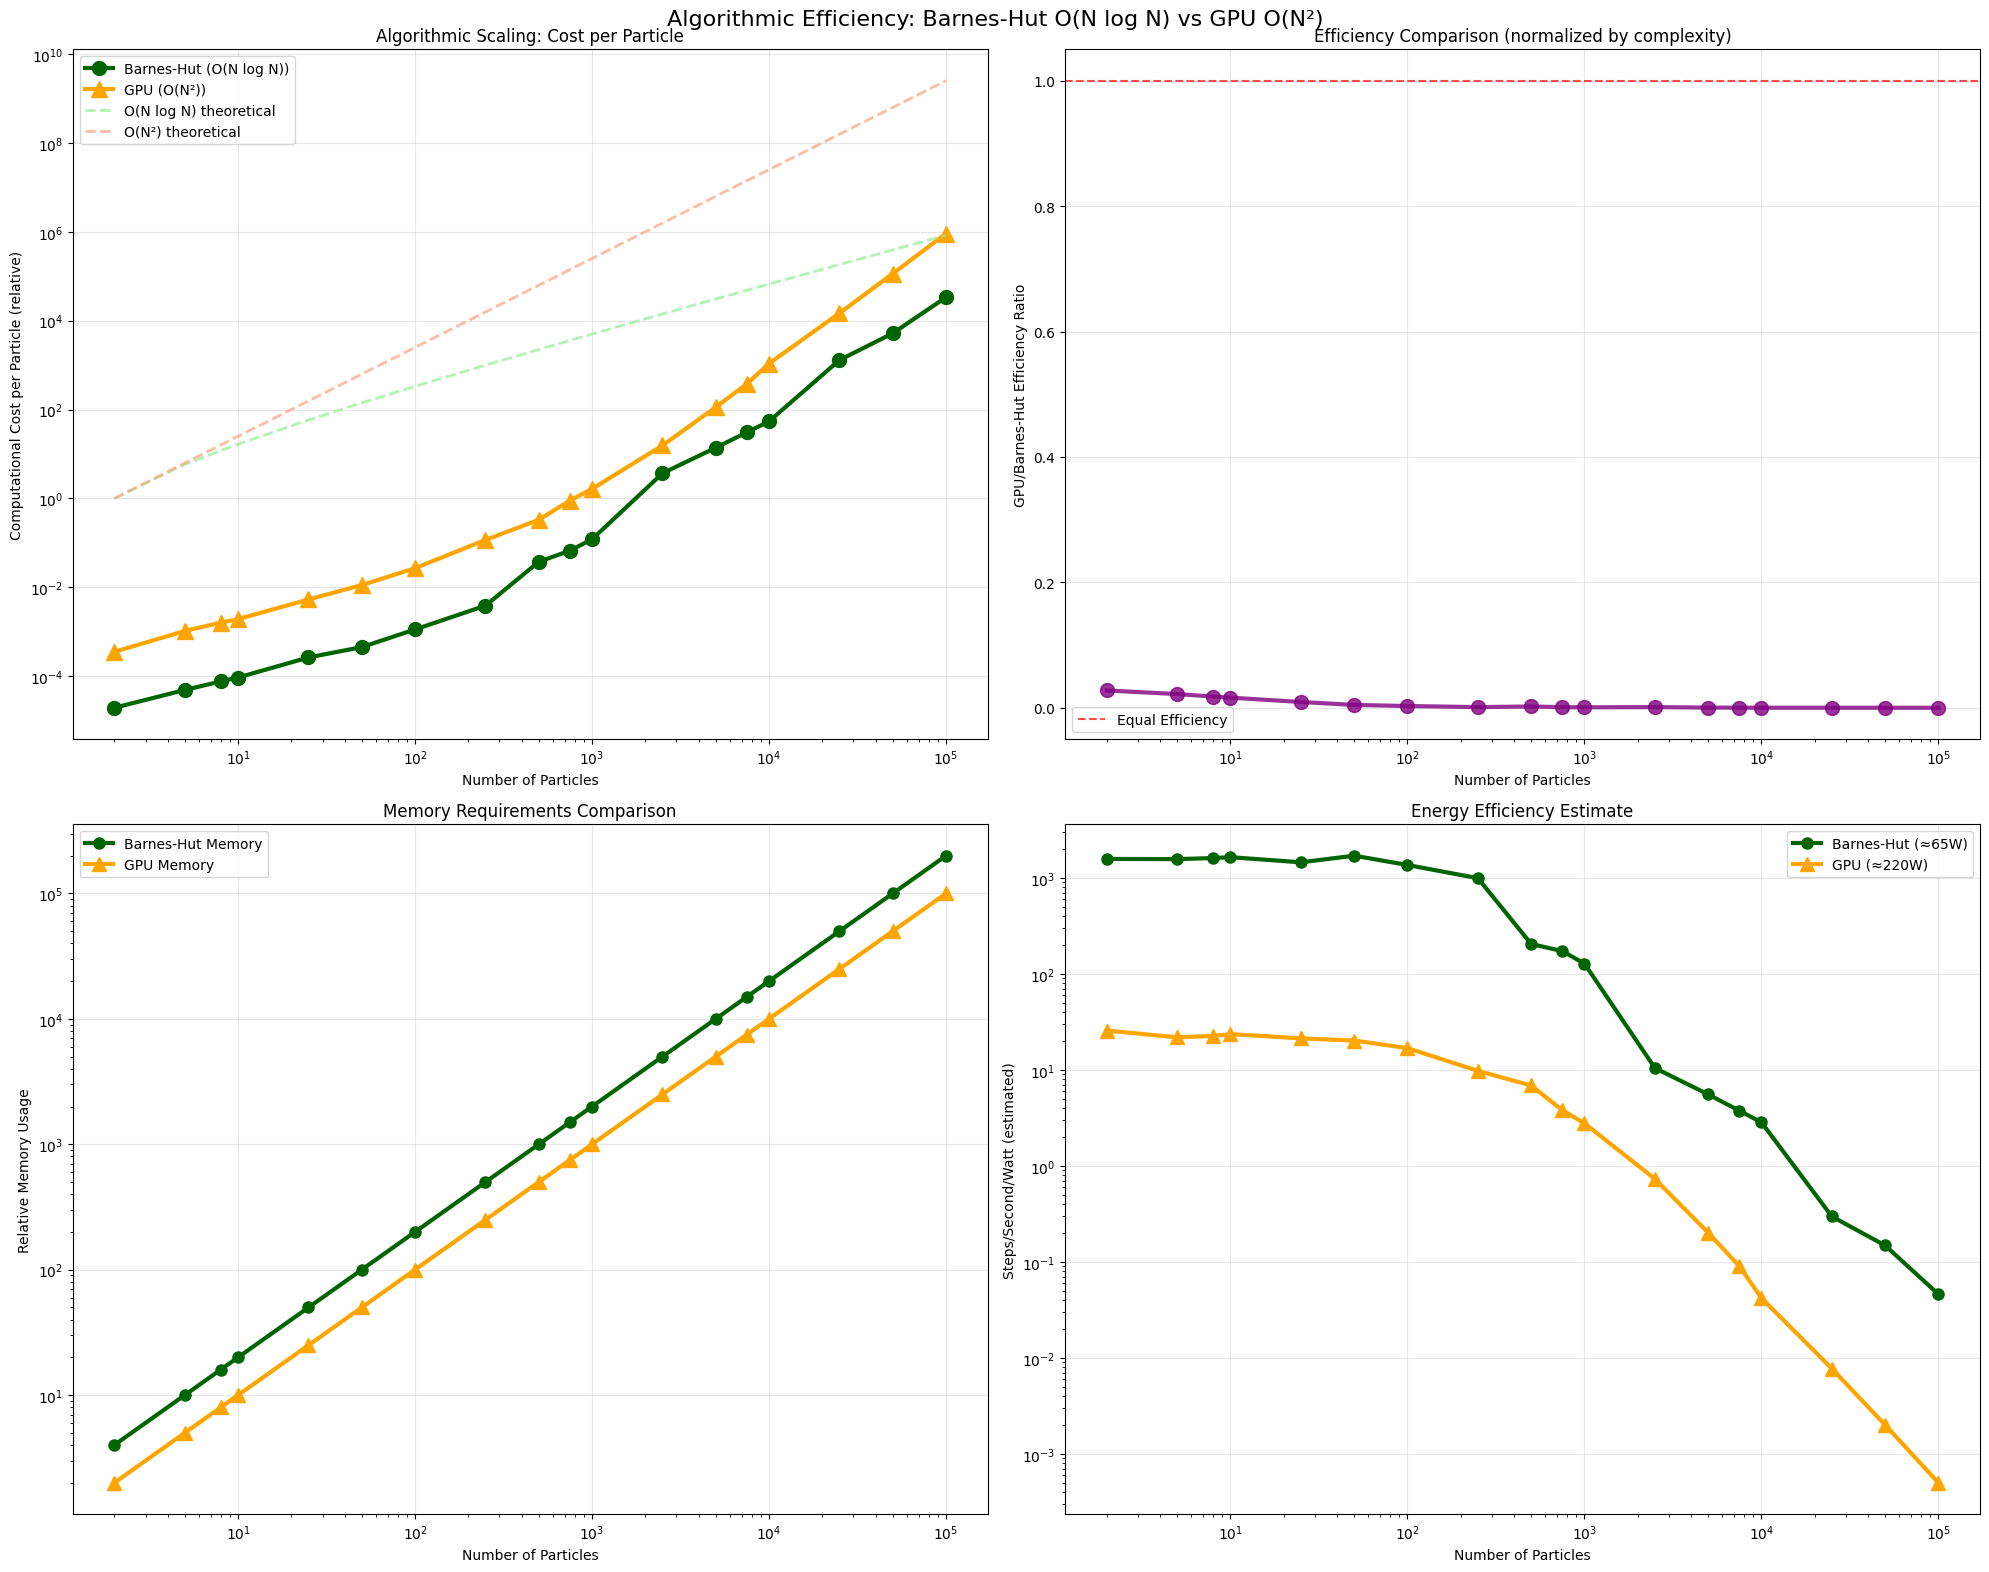

✅ Algorithmic efficiency analysis completata


In [4]:
# 3. ALGORITMIC EFFICIENCY AND MEMORY ANALYSIS
if data_available:
    
    print("\n=== ALGORITHMIC EFFICIENCY ANALYSIS ===")
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Algorithmic Efficiency: Barnes-Hut O(N log N) vs GPU O(N²)', fontsize=16)
    
    # Plot 1: Computational Cost per Particle
    ax1 = axes[0, 0]
    
    if not bh_common.empty:
        cost_per_particle_bh = 1 / (bh_common['MeanStepsPerSecond'] / bh_common['NumParticles'])  # Tempo per particella
        ax1.loglog(bh_common['NumParticles'], cost_per_particle_bh, 'o-',
                  label='Barnes-Hut (O(N log N))', color='darkgreen', linewidth=3, markersize=10)
    
    if not gpu_common.empty:
        cost_per_particle_gpu = 1 / (gpu_common['MeanStepsPerSecond'] / gpu_common['NumParticles'])
        ax1.loglog(gpu_common['NumParticles'], cost_per_particle_gpu, '^-',
                  label='GPU (O(N²))', color='orange', linewidth=3, markersize=12)
    
    # Theoretical scaling lines
    if common_particles:
        ref_particles = sorted(common_particles)
        n_array = np.array(ref_particles)
        
        # Normalize to smallest common value
        n_base = min(ref_particles)
        
        # O(N log N) theoretical
        theoretical_nlogn = (n_array / n_base) * (np.log2(n_array) / np.log2(n_base))
        ax1.loglog(ref_particles, theoretical_nlogn, '--', 
                  color='lightgreen', linewidth=2, alpha=0.7, label='O(N log N) theoretical')
        
        # O(N²) theoretical
        theoretical_n2 = (n_array / n_base)**2
        ax1.loglog(ref_particles, theoretical_n2, '--', 
                  color='lightsalmon', linewidth=2, alpha=0.7, label='O(N²) theoretical')
    
    ax1.set_xlabel('Number of Particles')
    ax1.set_ylabel('Computational Cost per Particle (relative)')
    ax1.set_title('Algorithmic Scaling: Cost per Particle')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Efficiency Ratio (Performance per theoretical complexity)
    ax2 = axes[0, 1]
    
    efficiency_ratios = []
    particles_for_efficiency = []
    
    for particles in common_particles:
        bh_data = bh_common[bh_common['NumParticles'] == particles]
        gpu_data = gpu_common[gpu_common['NumParticles'] == particles]
        
        if not bh_data.empty and not gpu_data.empty:
            bh_perf = bh_data['MeanStepsPerSecond'].iloc[0]
            gpu_perf = gpu_data['MeanStepsPerSecond'].iloc[0]
            
            # Normalize by theoretical complexity
            # Barnes-Hut efficiency = actual_perf / (N log N)
            # GPU efficiency = actual_perf / N²
            
            bh_efficiency = bh_perf / (particles * np.log2(particles))
            gpu_efficiency = gpu_perf / (particles * particles)
            
            if bh_efficiency > 0:
                efficiency_ratio = gpu_efficiency / bh_efficiency
                efficiency_ratios.append(efficiency_ratio)
                particles_for_efficiency.append(particles)
    
    if efficiency_ratios:
        ax2.semilogx(particles_for_efficiency, efficiency_ratios, 'o-', 
                    linewidth=3, markersize=10, color='purple', alpha=0.8)
        ax2.axhline(y=1, color='red', linestyle='--', alpha=0.7, 
                   label='Equal Efficiency')
        
    ax2.set_xlabel('Number of Particles')
    ax2.set_ylabel('GPU/Barnes-Hut Efficiency Ratio')
    ax2.set_title('Efficiency Comparison (normalized by complexity)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Memory Efficiency Analysis
    ax3 = axes[1, 0]
    
    # Theoretical memory requirements
    # Barnes-Hut: O(N) for particles + O(N) for tree ≈ 2N
    # GPU: O(N) for particles (assuming shared memory optimizations)
    
    if common_particles:
        memory_bh_relative = [2 * n for n in common_particles]  # 2N for BH tree
        memory_gpu_relative = [n for n in common_particles]     # N for GPU
        
        ax3.loglog(common_particles, memory_bh_relative, 'o-', 
                  label='Barnes-Hut Memory', color='darkgreen', linewidth=3, markersize=8)
        ax3.loglog(common_particles, memory_gpu_relative, '^-', 
                  label='GPU Memory', color='orange', linewidth=3, markersize=10)
        
        ax3.set_xlabel('Number of Particles')
        ax3.set_ylabel('Relative Memory Usage')
        ax3.set_title('Memory Requirements Comparison')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # Plot 4: Performance per Watt Estimation (rough approximation)
    ax4 = axes[1, 1]
    
    # Rough power consumption estimates (typical values)
    cpu_tdp = 65  # Watts for typical CPU
    gpu_tdp = 220  # Watts for typical GPU
    
    if not bh_common.empty and not gpu_common.empty:
        perf_per_watt_bh = bh_common['MeanStepsPerSecond'] / cpu_tdp
        perf_per_watt_gpu = gpu_common['MeanStepsPerSecond'] / gpu_tdp
        
        ax4.loglog(bh_common['NumParticles'], perf_per_watt_bh, 'o-',
                  label=f'Barnes-Hut (≈{cpu_tdp}W)', color='darkgreen', linewidth=3, markersize=8)
        ax4.loglog(gpu_common['NumParticles'], perf_per_watt_gpu, '^-',
                  label=f'GPU (≈{gpu_tdp}W)', color='orange', linewidth=3, markersize=10)
        
        ax4.set_xlabel('Number of Particles')
        ax4.set_ylabel('Steps/Second/Watt (estimated)')
        ax4.set_title('Energy Efficiency Estimate')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Algorithmic efficiency analysis completata")

In [5]:
# 4. FINAL SUMMARY AND RECOMMENDATIONS
if data_available:
    
    print("\n=== SUMMARY TABLE: BARNES-HUT vs GPU ===")
    
    summary_data = []
    
    # Performance ranges analysis
    ranges = [
        (1, 1000, "Small (1-1K)"),
        (1001, 5000, "Medium (1K-5K)"),
        (5001, 25000, "Large (5K-25K)"),
        (25001, 100000, "Very Large (25K-100K)")
    ]
    
    for min_n, max_n, range_name in ranges:
        bh_range = df_cpu_bh_1t[(df_cpu_bh_1t['NumParticles'] >= min_n) & 
                                (df_cpu_bh_1t['NumParticles'] <= max_n)]
        gpu_range = df_gpu_high[(df_gpu_high['NumParticles'] >= min_n) & 
                                (df_gpu_high['NumParticles'] <= max_n)]
        
        row = {'Range': range_name}
        
        if not bh_range.empty:
            best_bh = bh_range.loc[bh_range['MeanStepsPerSecond'].idxmax()]
            avg_bh = bh_range['MeanStepsPerSecond'].mean()
            row.update({
                'BH_Best': f"{best_bh['MeanStepsPerSecond']:.1e}",
                'BH_Avg': f"{avg_bh:.1e}",
                'BH_Best_N': f"{best_bh['NumParticles']:,}"
            })
        
        if not gpu_range.empty:
            best_gpu = gpu_range.loc[gpu_range['MeanStepsPerSecond'].idxmax()]
            avg_gpu = gpu_range['MeanStepsPerSecond'].mean()
            row.update({
                'GPU_Best': f"{best_gpu['MeanStepsPerSecond']:.1e}",
                'GPU_Avg': f"{avg_gpu:.1e}",
                'GPU_Best_N': f"{best_gpu['NumParticles']:,}"
            })
        
        # Determine winner for this range
        if not bh_range.empty and not gpu_range.empty:
            bh_best_val = bh_range['MeanStepsPerSecond'].max()
            gpu_best_val = gpu_range['MeanStepsPerSecond'].max()
            
            if gpu_best_val > bh_best_val:
                winner = "GPU"
                advantage = gpu_best_val / bh_best_val
            else:
                winner = "Barnes-Hut"
                advantage = bh_best_val / gpu_best_val
            
            row['Winner'] = f"{winner} ({advantage:.2f}x)"
        
        summary_data.append(row)
    
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))
    
    # Overall analysis
    print(f"\n=== OVERALL PERFORMANCE ANALYSIS ===")
    
    if not df_cpu_bh_1t.empty and not df_gpu_high.empty:
        # Peak performances
        peak_bh = df_cpu_bh_1t['MeanStepsPerSecond'].max()
        peak_bh_n = df_cpu_bh_1t.loc[df_cpu_bh_1t['MeanStepsPerSecond'].idxmax(), 'NumParticles']
        
        peak_gpu = df_gpu_high['MeanStepsPerSecond'].max()
        peak_gpu_n = df_gpu_high.loc[df_gpu_high['MeanStepsPerSecond'].idxmax(), 'NumParticles']
        
        print(f"🏆 Barnes-Hut Peak: {peak_bh:.1e} steps/sec at {peak_bh_n:,} particles")
        print(f"🚀 GPU Peak: {peak_gpu:.1e} steps/sec at {peak_gpu_n:,} particles")
        
        if peak_gpu > peak_bh:
            print(f"   → GPU is {peak_gpu/peak_bh:.2f}x faster at peak performance")
        else:
            print(f"   → Barnes-Hut is {peak_bh/peak_gpu:.2f}x faster at peak performance")
        
        # Average performance comparison
        avg_bh = df_cpu_bh_1t['MeanStepsPerSecond'].mean()
        avg_gpu = df_gpu_high['MeanStepsPerSecond'].mean()
        
        print(f"\n📊 Average Performance:")
        print(f"   Barnes-Hut: {avg_bh:.1e} steps/sec")
        print(f"   GPU: {avg_gpu:.1e} steps/sec")
        print(f"   Ratio: GPU is {avg_gpu/avg_bh:.2f}x faster on average")
    
    # Recommendations
    print(f"\n🎯 FINAL RECOMMENDATIONS:")
    
    if crossover_found and crossover_particles:
        print(f"1. **Crossover Point**: GPU becomes faster at ≈{crossover_particles:,} particles")
        print(f"   - Use Barnes-Hut for N < {crossover_particles:,}")
        print(f"   - Use GPU for N ≥ {crossover_particles:,}")
    else:
        gpu_better_count = sum(1 for s in speedups if s > 1) if 'speedups' in locals() else 0
        total_comparisons = len(speedups) if 'speedups' in locals() else 0
        
        if total_comparisons > 0:
            gpu_advantage_pct = (gpu_better_count / total_comparisons) * 100
            
            if gpu_advantage_pct > 70:
                print("1. **GPU Recommended**: GPU is faster in most tested scenarios")
            elif gpu_advantage_pct < 30:
                print("1. **Barnes-Hut Recommended**: Barnes-Hut is faster in most scenarios")
            else:
                print("1. **Mixed Results**: Performance depends on specific particle count")
    
    print("2. **Algorithmic Considerations**:")
    print("   - Barnes-Hut: O(N log N) complexity, better for large N theoretically")
    print("   - GPU: O(N²) complexity but massive parallelism")
    print("   - Memory: Barnes-Hut uses ~2x memory for tree structure")
    
    print("3. **Implementation Factors**:")
    print("   - Barnes-Hut: Single-threaded optimal, tree building overhead")
    print("   - GPU: Parallel processing, memory bandwidth limited")
    print("   - Energy: Barnes-Hut more efficient per watt typically")
    
    print("4. **Use Case Guidance**:")
    print("   - Real-time simulations: Choose based on crossover point")
    print("   - Batch processing: Consider both performance and energy costs")
    print("   - Research: Barnes-Hut for accuracy, GPU for speed")

print("\n✅ Barnes-Hut vs GPU analysis completata!")
print("🎯 Use this analysis to choose the optimal method for your N-body simulations")


=== SUMMARY TABLE: BARNES-HUT vs GPU ===
                Range BH_Best  BH_Avg BH_Best_N GPU_Best GPU_Avg GPU_Best_N              Winner
         Small (1-1K) 1.1e+05 7.3e+04        50  5.7e+03 3.5e+03          2 Barnes-Hut (19.61x)
       Medium (1K-5K) 6.8e+02 5.2e+02     2,500  1.6e+02 1.0e+02      2,500  Barnes-Hut (4.23x)
       Large (5K-25K) 2.4e+02 1.5e+02     7,500  2.0e+01 1.0e+01      7,500 Barnes-Hut (12.30x)
Very Large (25K-100K) 9.6e+00 6.3e+00    50,000  4.4e-01 2.8e-01     50,000 Barnes-Hut (21.91x)

=== OVERALL PERFORMANCE ANALYSIS ===
🏆 Barnes-Hut Peak: 1.1e+05 steps/sec at 50 particles
🚀 GPU Peak: 5.7e+03 steps/sec at 2 particles
   → Barnes-Hut is 19.61x faster at peak performance

📊 Average Performance:
   Barnes-Hut: 4.5e+04 steps/sec
   GPU: 2.2e+03 steps/sec
   Ratio: GPU is 0.05x faster on average

🎯 FINAL RECOMMENDATIONS:
1. **Barnes-Hut Recommended**: Barnes-Hut is faster in most scenarios
2. **Algorithmic Considerations**:
   - Barnes-Hut: O(N log N) comple